In [10]:
# === BIBLIOTECAS NECESSÁRIAS ===
# Manipulação de dados e cálculos numéricos
import pandas as pd 
import numpy as np  
# Visualização estática (gráficos tradicionais)
import matplotlib.pyplot as plt 
import seaborn as sns            
# Manipulação de datas
from datetime import datetime  
# Visualização interativa e dinâmica
import plotly.express as px     
import plotly.graph_objects as go 
from plotly.subplots import make_subplots 
# Manipulação de arquivos e sistemas
import glob
import os  
# Expressões regulares
import re 

In [3]:
# 1) Carregar e concatenar os dados dos processos judiciais da pasta uploads
# Exibição no console
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.max_rows', 200)

# Listar os arquivos CSV na pasta 'uploads'
arquivos_csv = glob.glob('uploads/processos_*.csv')

# Carregar os arquivos CSV e concatenar em um único DataFrame
dfs = []
tamanho_total_bytes = 0   # Somar os tamanhos dos arquivos
for arquivo in arquivos_csv:
    # Extrair o ano do nome do arquivo
    ano = int(arquivo.split('_')[-1].split('.')[0])
    
    # Soma o tamanho de cada arquivo à variável
    tamanho_total_bytes += os.path.getsize(arquivo)
    
    df_ano = pd.read_csv(arquivo, sep=',', encoding='utf-8')
    df_ano['ano_arquivo'] = ano  # Adicionar coluna com o ano do arquivo
    dfs.append(df_ano)

print("\n=== Arquivo carregado com sucesso! ===")
df_juridico = pd.concat(dfs, ignore_index=True)
print("Dimensões (linhas, colunas):", df_juridico.shape)

# Tamanho do arquivo
file_size_mb = tamanho_total_bytes / (1024**2)
print(f"Tamanho total dos arquivos CSV no disco: {file_size_mb:.2f} MB")

# Verificação de valores vazios ou nulos no DataFrame df_juridico
print("\n=== Verificação de Valores Nulos/Vazios ===")

# Contar o total de valores nulos por coluna
valores_nulos_por_coluna = df_juridico.isnull().sum()

# Filtrar para mostrar apenas as colunas que de fato contêm valores nulos
colunas_com_nulos = valores_nulos_por_coluna[valores_nulos_por_coluna > 0]

if colunas_com_nulos.empty:
    print("Não foram encontrados valores nulos ou vazios no DataFrame.")
else:
    print("Foram encontrados valores nulos nas seguintes colunas:")
    
    # Criar um DataFrame de resumo para uma visualização clara
    total_registros = len(df_juridico)
    df_resumo_nulos = pd.DataFrame({
        'Qtd Nulos': colunas_com_nulos,
        'Percentual (%)': (colunas_com_nulos / total_registros) * 100
    })
    
    # Ordenar o resultado pela coluna de percentual, do maior para o menor
    df_resumo_nulos_sorted = df_resumo_nulos.sort_values(by='Percentual (%)', ascending=False)
    
    # Formatar a coluna de percentual para exibir com duas casas decimais e o símbolo '%'
    df_resumo_nulos_sorted['Percentual (%)'] = df_resumo_nulos_sorted['Percentual (%)'].map('{:.2f}%'.format)
    
    # Exibir a tabela-resumo
    print(df_resumo_nulos_sorted)

# Guardar uma cópia de trabalho
df = df_juridico.copy()


=== Arquivo carregado com sucesso! ===
Dimensões (linhas, colunas): (4944351, 11)
Tamanho total dos arquivos CSV no disco: 726.09 MB

=== Verificação de Valores Nulos/Vazios ===
Foram encontrados valores nulos nas seguintes colunas:
             Qtd Nulos Percentual (%)
data_baixa     1749238         35.38%
codg_classe          2          0.00%


In [4]:
# 2) Tratamento dos Dados para Advogados
# Tratamento das colunas
df['data_distribuicao'] = pd.to_datetime(df['data_distribuicao'], errors='coerce')
df['ano_distribuicao'] = df['data_distribuicao'].dt.year # Criar coluna de ano de distribuição
df['is_segredo_justica'] = df['is_segredo_justica'].astype(bool)

# Tratamento dos números de OAB
def is_oab_valida(oab):
    """
    Verifica se um número de OAB é válido seguindo o formato:
    NÚMEROS + LETRA + ESPAÇO + UF. Ex: '2153421N GO'
    """
    if not isinstance(oab, str) or not oab.strip():
        return False
    oab_limpa = oab.upper().strip()
    ufs_validas = ['GO', 'DF', 'SP', 'RJ', 'MG', 'RS', 'SC', 'PR', 'BA', 'PE',
                  'CE', 'MA', 'ES', 'AL', 'SE', 'PB', 'RN', 'PI', 'MT', 'MS', 
                  'TO', 'PA', 'AP', 'AM', 'RR', 'AC', 'RO'
                  ]
    padrao_regex = re.compile(f"^[1-9]\\d*[A-Z]\\s({'|'.join(ufs_validas)})$")
    return bool(padrao_regex.match(oab_limpa))

# Aplicar a validação de OAB
df['oab_valida'] = df['oab'].apply(is_oab_valida)

# Contar e exibir a quantidade de OABs inválidas
registros_invalidos = df[df['oab_valida'] == False]
qtd_invalidos = len(registros_invalidos)

print("\n=== Validação de Registros de OAB ===")
print(f"Total de registros com OAB em formato inválido ou nulo: {qtd_invalidos}")

if qtd_invalidos > 0:
    exemplos_invalidos = registros_invalidos['oab'].unique()
    print(f"Exemplos de OABs inválidas: {exemplos_invalidos}")
print("\n" + "="*100 + "\n")

# Dataframe com apenas OABs válidas
df_validos = df[df['oab_valida'] == True].copy()

# Verificar se valores NULL ou Vazios

print("\n=== Dataframe com apenas OAB's válidas ===")
display(df_validos.head())


=== Validação de Registros de OAB ===
Total de registros com OAB em formato inválido ou nulo: 20335
Exemplos de OABs inválidas: ['GO' '0A RJ' '0A MT' '0S GO' '0A MG' '0S MT' '0S DF' '0S MA' '0A PE' 'TO'
 '0A MS' '0S AL' '0S CE' '0S SC' '0S MG' '0S MS' '0S RS' '0S RN' '0A TO'
 '0A SE' '0S PE' '0A RS' '0S TO']



=== Dataframe com apenas OAB's válidas ===


,processo,data_distribuicao,data_baixa,entrancia,comarca,serventia,is_segredo_justica,codg_classe,oab,codg_assunto,ano_arquivo,ano_distribuicao,oab_valida
0,0119071.75.2004.8.09.0051,2022-05-25,2022-06-30,FINAL,GOIÂNIA,2ª Vara Cível,False,7.0,19365N GO,10671,2022,2022,True
1,0189657.40.2004.8.09.0051,2022-06-02,2024-01-22,FINAL,GOIÂNIA,31ª Vara Cível,False,7.0,10647N GO,10671,2022,2022,True
2,0189657.40.2004.8.09.0051,2022-06-02,2024-01-22,FINAL,GOIÂNIA,31ª Vara Cível,False,7.0,167974A SP,10671,2022,2022,True
3,0189657.40.2004.8.09.0051,2022-06-02,2024-01-22,FINAL,GOIÂNIA,31ª Vara Cível,False,7.0,20763N GO,10671,2022,2022,True
4,0197944.89.2004.8.09.0051,2022-06-07,2022-10-07,FINAL,GOIÂNIA,22ª Vara Cível,False,7.0,20785N GO,10671,2022,2022,True


In [5]:
# 3) Análise de Processos Sigilosos e Não Sigilosos por OAB válida
# Agrupar por 'oab' e 'is_segredo_justica' e contar a quantidade de processos
df_analise = df_validos.groupby(['oab', 'is_segredo_justica']).size().reset_index(name='qtd_processos')

# Ordenar os resultados para melhor visualização (pela OAB e depois pela quantidade)
df_analise_sorted = df_analise.sort_values(by=['oab', 'qtd_processos'], ascending=[True, False])

print("\n=== Tabela de Processos Sigilosos e Não Sigilosos por OAB ===")
display(df_analise_sorted.head(10))

# Para uma visualização mais clara, "pivotei" a tabela
# Criando colunas separadas para processos sigilosos e não sigilosos
df_pivot = df_analise.pivot_table(
    index='oab',
    columns='is_segredo_justica',
    values='qtd_processos',
    fill_value=0 # Preenche com 0 OABs que não têm um dos tipos
)

# Renomear as colunas (False -> nao_sigilosos, True -> sigilosos)
df_pivot = df_pivot.rename(columns={False: 'nao_sigilosos', True: 'sigilosos'})

# Adicionar uma coluna de total e ordenar pelos advogados com mais processos
df_pivot['total_processos'] = df_pivot['nao_sigilosos'] + df_pivot['sigilosos']
df_pivot_sorted = df_pivot.sort_values(by='total_processos', ascending=False)


print("\n=== Tabela Pivotada: Contagem por OAB ===")
display(df_pivot_sorted.head(10))


=== Tabela de Processos Sigilosos e Não Sigilosos por OAB ===


,oab,is_segredo_justica,qtd_processos
0,100005A PR,False,8
1,100006A PR,False,2
2,100006S RS,False,17
3,100008A RJ,True,1
4,10000N GO,False,16
5,100018A RS,False,1
6,10001A DF,False,1
7,10001A MS,False,1
8,10001A TO,False,1
9,10001N GO,False,58



=== Tabela Pivotada: Contagem por OAB ===


is_segredo_justica,nao_sigilosos,sigilosos,total_processos
oab,,,
16315N GO,86839.0,439.0,87278.0
21735N GO,71783.0,1548.0,73331.0
40240N GO,69514.0,1239.0,70753.0
38664N GO,43965.0,3617.0,47582.0
36056N GO,29732.0,518.0,30250.0
28449A GO,28525.0,683.0,29208.0
9632N GO,28435.0,4.0,28439.0
19417N GO,28226.0,3.0,28229.0
31989N GO,25473.0,232.0,25705.0


In [ ]:
# 4) Cálculo de Estatísticas Descritivas (Medidas de Tendência Central)
print("=== ESTATÍSTICAS DESCRITIVAS DE PROCESSOS POR OAB VÁLIDA ===")

# Análise Geral (Total de Processos)
# Distribuição do número total de processos por advogado.
print("--- Análise Geral (Total de Processos por OAB) ---")
total_counts = df_pivot_sorted['total_processos']

# Cálculo das métricas
media_geral = total_counts.mean()
mediana_geral = total_counts.median()
moda_geral = total_counts.mode()

print(f"Média de processos por OAB: {media_geral:.2f}")
print(f"Mediana de processos por OAB: {mediana_geral}")
# A moda pode retornar múltiplos valores se houver empate; pegamos o primeiro.
if not moda_geral.empty:
    print(f"Moda de processos por OAB: {moda_geral.iloc[0]}")
else:
    print("Moda: Não há um valor único que seja o mais frequente.")


# Análise de Processos NÃO SIGILOSOS
# Foco na distribuição de processos públicos por advogado.
print("\n--- Análise de Processos NÃO SIGILOSOS por OAB ---")
nao_sigilosos_counts = df_pivot_sorted['nao_sigilosos']

# Cálculo das métricas
media_nao_sigilosos = nao_sigilosos_counts.mean()
mediana_nao_sigilosos = nao_sigilosos_counts.median()
moda_nao_sigilosos = nao_sigilosos_counts.mode()

print(f"Média de processos não sigilosos por OAB: {media_nao_sigilosos:.2f}")
print(f"Mediana de processos não sigilosos por OAB: {mediana_nao_sigilosos}")
if not moda_nao_sigilosos.empty:
    print(f"Moda de processos não sigilosos por OAB: {moda_nao_sigilosos.iloc[0]}")
else:
    print("Moda: Não há um valor único que seja o mais frequente.")


# Análise de Processos SIGILOSOS
# Foco na distribuição de processos em segredo de justiça por advogado.
print("\n--- Análise de Processos SIGILOSOS por OAB ---")
sigilosos_counts = df_pivot_sorted['sigilosos']

# Cálculo das métricas
media_sigilosos = sigilosos_counts.mean()
mediana_sigilosos = sigilosos_counts.median()
moda_sigilosos = sigilosos_counts.mode()

print(f"Média de processos sigilosos por OAB: {media_sigilosos:.2f}")
print(f"Mediana de processos sigilosos por OAB: {mediana_sigilosos}")
if not moda_sigilosos.empty:
    print(f"Moda de processos sigilosos por OAB: {moda_sigilosos.iloc[0]}")
else:
    print("Moda: Não há um valor único que seja o mais frequente.")
print("\n" + "="*100 + "\n")

=== ESTATÍSTICAS DESCRITIVAS DE PROCESSOS POR OAB VÁLIDA ===
--- Análise Geral (Total de Processos por OAB) ---
Média de processos por OAB: 43.27
Mediana de processos por OAB: 3.0
Moda de processos por OAB: 1.0

--- Análise de Processos NÃO SIGILOSOS por OAB ---
Média de processos não sigilosos por OAB: 36.71
Mediana de processos não sigilosos por OAB: 3.0
Moda de processos não sigilosos por OAB: 1.0

--- Análise de Processos SIGILOSOS por OAB ---
Média de processos sigilosos por OAB: 6.56
Mediana de processos sigilosos por OAB: 0.0
Moda de processos sigilosos por OAB: 0.0





=== VISUALIZAÇÃO GRÁFICA DAS ESTATÍSTICAS ===



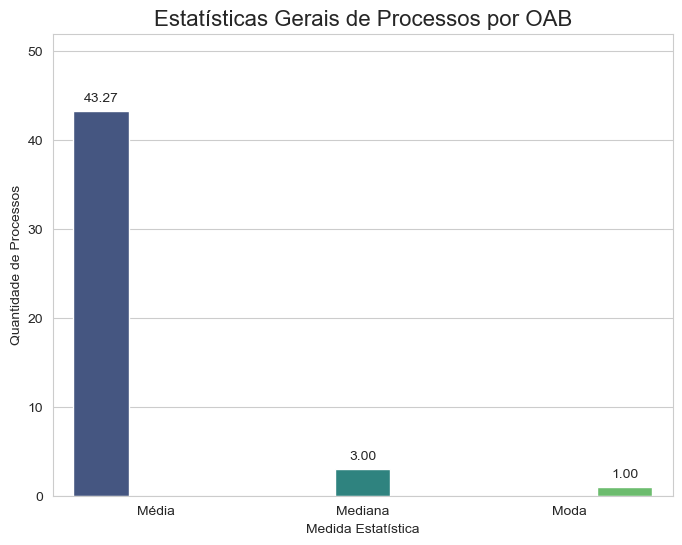

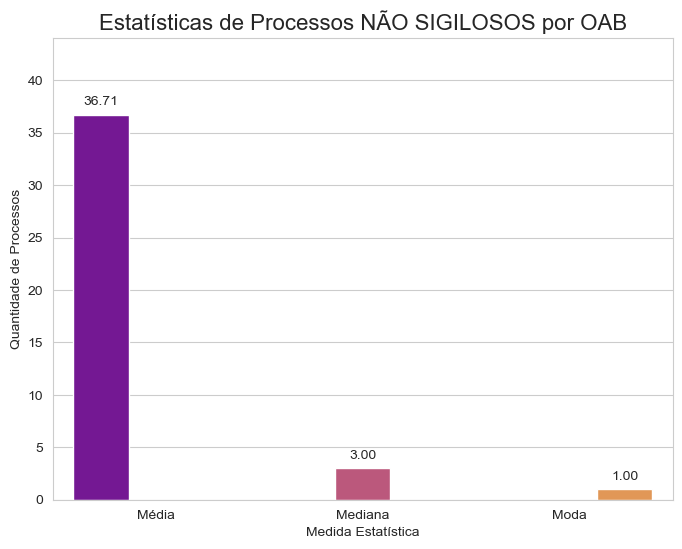

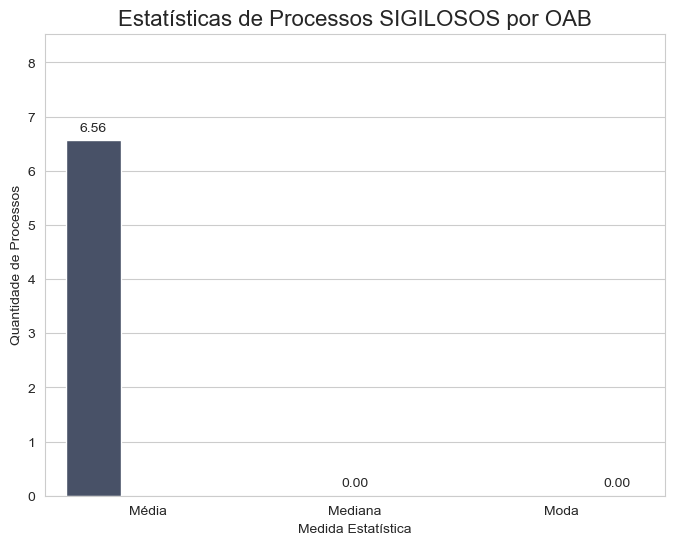

In [14]:
# 5) Visualização Gráfica das Estatísticas
# Configurar um estilo estético para os gráficos
sns.set_style("whitegrid")
# A paleta de cores será definida dentro de cada gráfico

print("\n" + "="*100)
print("=== VISUALIZAÇÃO GRÁFICA DAS ESTATÍSTICAS ===")
print("="*100 + "\n")

# --- 5.1) Gráfico para Análise Geral ---

# Preparar os dados para o gráfico
dados_geral = {
    'Métrica': ['Média', 'Mediana', 'Moda'],
    'Valor': [media_geral, mediana_geral, moda_geral.iloc[0] if not moda_geral.empty else 0]
}
df_plot_geral = pd.DataFrame(dados_geral)

# Criar o gráfico
plt.figure(figsize=(8, 6))
ax_geral = sns.barplot(x='Métrica', y='Valor', data=df_plot_geral, palette='viridis', hue='Métrica')

ax_geral.get_legend().remove()

# Adicionar o valor exato no topo de cada coluna
for p in ax_geral.patches:
    ax_geral.annotate(f'{p.get_height():.2f}', 
                      (p.get_x() + p.get_width() / 2., p.get_height()), 
                      ha = 'center', va = 'center', 
                      xytext = (0, 9), 
                      textcoords = 'offset points')

plt.title('Estatísticas Gerais de Processos por OAB', fontsize=16)
plt.ylabel('Quantidade de Processos')
plt.xlabel('Medida Estatística')
plt.ylim(0, media_geral * 1.2)
plt.show()


# --- 5.2) Gráfico para Processos NÃO SIGILOSOS ---

# Preparar os dados para o gráfico
dados_nao_sigilosos = {
    'Métrica': ['Média', 'Mediana', 'Moda'],
    'Valor': [media_nao_sigilosos, mediana_nao_sigilosos, moda_nao_sigilosos.iloc[0] if not moda_nao_sigilosos.empty else 0]
}
df_plot_nao_sigilosos = pd.DataFrame(dados_nao_sigilosos)

# Criar o gráfico
plt.figure(figsize=(8, 6))
ax_nao_sigiloso = sns.barplot(x='Métrica', y='Valor', data=df_plot_nao_sigilosos, palette='plasma', hue='Métrica')

ax_nao_sigiloso.get_legend().remove()

# Adicionar o valor exato no topo de cada coluna
for p in ax_nao_sigiloso.patches:
    ax_nao_sigiloso.annotate(f'{p.get_height():.2f}', 
                             (p.get_x() + p.get_width() / 2., p.get_height()), 
                             ha = 'center', va = 'center', 
                             xytext = (0, 9), 
                             textcoords = 'offset points')

plt.title('Estatísticas de Processos NÃO SIGILOSOS por OAB', fontsize=16)
plt.ylabel('Quantidade de Processos')
plt.xlabel('Medida Estatística')
plt.ylim(0, media_nao_sigilosos * 1.2)
plt.show()


# --- 5.3) Gráfico para Processos SIGILOSOS ---

# Preparar os dados para o gráfico
dados_sigilosos = {
    'Métrica': ['Média', 'Mediana', 'Moda'],
    'Valor': [media_sigilosos, mediana_sigilosos, moda_sigilosos.iloc[0] if not moda_sigilosos.empty else 0]
}
df_plot_sigilosos = pd.DataFrame(dados_sigilosos)

# Criar o gráfico
plt.figure(figsize=(8, 6))
ax_sigiloso = sns.barplot(x='Métrica', y='Valor', data=df_plot_sigilosos, palette='cividis', hue='Métrica')

ax_sigiloso.get_legend().remove()

# Adicionar o valor exato no topo de cada coluna
for p in ax_sigiloso.patches:
    ax_sigiloso.annotate(f'{p.get_height():.2f}', 
                       (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha = 'center', va = 'center', 
                       xytext = (0, 9), 
                       textcoords = 'offset points')

plt.title('Estatísticas de Processos SIGILOSOS por OAB', fontsize=16)
plt.ylabel('Quantidade de Processos')
plt.xlabel('Medida Estatística')
plt.ylim(0, media_sigilosos * 1.3)
plt.show()

# 📊 Análise Interpretativa dos Resultados Estatísticos (Média, Mediana e Moda)

## 💡 Interpretação Geral

A conclusão mais importante, que é vista nos três casos, é a existência de uma **distribuição de processos extremamente assimétrica e desigual**. Em outras palavras, há uma concentração massiva de processos em um número relativamente pequeno de advogados, enquanto a grande maioria dos advogados atua em pouquíssimos casos.

Esse fenômeno é claramente indicado pela **enorme diferença entre a MÉDIA e a MEDIANA/MODA**.

- A **Média** é muito sensível a valores extremos (outliers).
- A **Mediana** e a **Moda** representam melhor o advogado "típico" ou o cenário "mais comum".

> Quando a média é muito maior que a mediana, como é o caso, isso significa que existem alguns "pontos fora da curva" com valores altíssimos que estão "puxando" a média para cima.

---

## 🔎 Análise Detalhada dos Resultados

### ⚖️ 1. Análise Geral (Total de Processos por OAB)

* **⭐ Moda de 1.0:** O número de processos que mais se repete entre os advogados é apenas **1**, ou seja, o cenário mais comum é um advogado ter um único processo.
* **↔️ Mediana de 3.0:** Se organizarmos todos os advogados em uma fila, do que tem menos processos para o que tem mais (ordem crescente), o advogado que está exatamente no meio da fila tem **3 processos**. Isso significa que **metade de todos os advogados tem 3 processos ou menos**.
* **🧮 Média de 43.27:** Embora o advogado típico tenha apenas 3 processos, a média geral é de 43. Isso é causado por um grupo seleto de advogados (provavelmente grandes escritórios ou especialistas em contencioso de massa) que possuem centenas ou milhares de processos, inflando drasticamente a média.

> **Conclusão:** Portanto, conforme os dados, é possível notar que o advogado típico tem poucos casos, mas uma minoria concentra a maior parte dos processos.

### 📖 2. Análise de Processos NÃO SIGILOSOS por OAB

* **⭐ Moda de 1.0 e ↔️ Mediana de 3.0:** O padrão se repete. O advogado típico também tem entre 1 e 3 processos que não são sigilosos.
* **🧮 Média de 36.71:** Este valor é alto e próximo da média geral (43.27).

> **Conclusão:** A grande desigualdade que vemos na análise geral é **majoritariamente impulsionada pelos processos não sigilosos**. Isso faz sentido, pois áreas que geram alto volume de casos, como direito do consumidor ou tributário, geralmente não correm em segredo de justiça.

### 🔒 3. Análise de Processos SIGILOSOS por OAB

Esta é a análise mais reveladora sobre especialização.

* **⭐ Moda de 0.0:** O cenário mais comum é um advogado ter **nenhum processo sigiloso**.
* **↔️ Mediana de 0.0:** **Pelo menos metade de todos os advogados não tem um único processo sigiloso**. Isso reforça a ideia de que a atuação em casos sigilosos não é a norma.
* **🧮 Média de 6.56:** Este é o ponto crucial. Mesmo que a maioria não tenha nenhum processo sigiloso, a média é positiva. Isso significa que a minoria de advogados que **atua** com processos sigilosos (áreas como direito de família, criminal, etc.) tende a ter um número relevante desses processos.

> **Conclusão:** A atuação em processos que correm em segredo de justiça parece ser um **nicho de especialização**. A maioria dos advogados não atua nessa área, mas aqueles que atuam o fazem com uma frequência que se destaca.

---

## 🏆 Resumo das Descobertas (Insights)

1.  **🎯 Atuação Concentrada:** Os dados não mostram uma distribuição equilibrada de trabalho. Um pequeno percentual de advogados/escritórios domina o volume de processos.
2.  **👤 O Advogado "Típico" vs. a Média:** O advogado "comum" tem entre 1 e 3 processos. A média de 43 é uma ilusão estatística criada por outliers e não representa a realidade da maioria.
3.  **🚀A Atuação em Ações Repetitivas é a Chave da Desigualdade:** O alto volume de processos está concentrado em casos públicos (não sigilosos), sugerindo atuação em advocacia de massa.
4.  **💼 Segredo de Justiça como Especialidade:** Atuar em processos sigilosos é para um grupo específico de advogados. A maioria não tem contato com essa área, indicando uma clara divisão de especialidades.


=== VISUALIZAÇÃO DA DISTRIBUIÇÃO COM BOXPLOTS ===

--- 6.1) Análise Geral: Total de Processos por OAB ---
Primeiro, a visualização completa para entendermos a escala dos outliers...


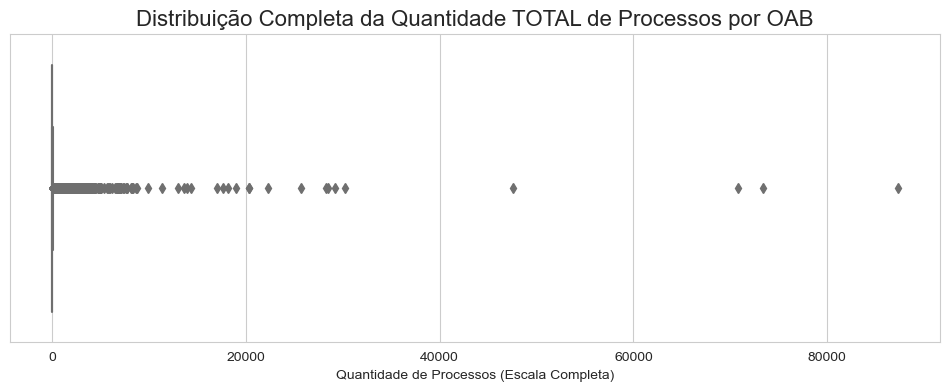


Agora, um zoom na distribuição, focando nos 95% dos advogados com menos processos (até 153 processos)...


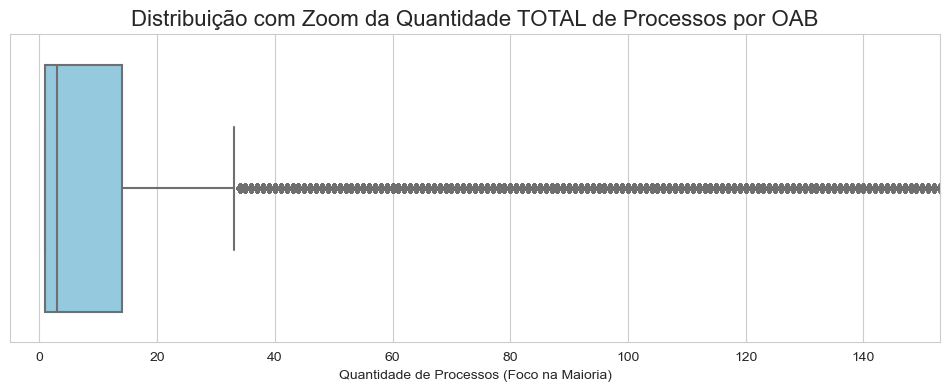


--- 6.2) Análise de Processos NÃO SIGILOSOS por OAB ---
Visão completa da distribuição dos processos não sigilosos...


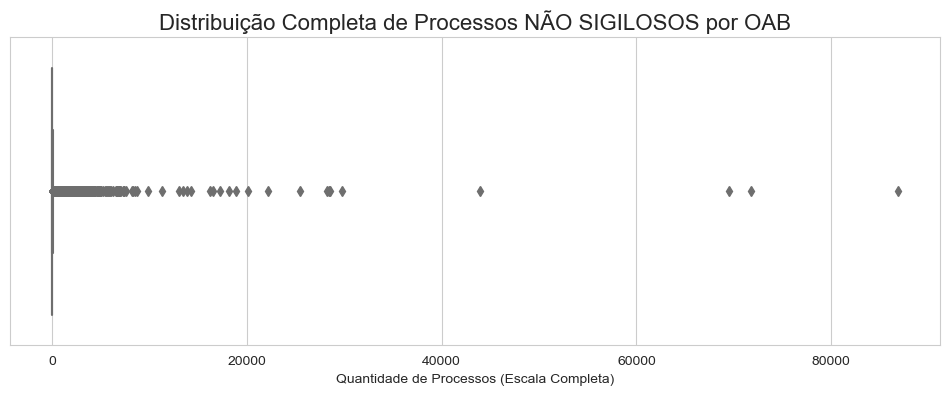


Zoom nos 95% dos advogados com menos processos não sigilosos (até 117 processos)...


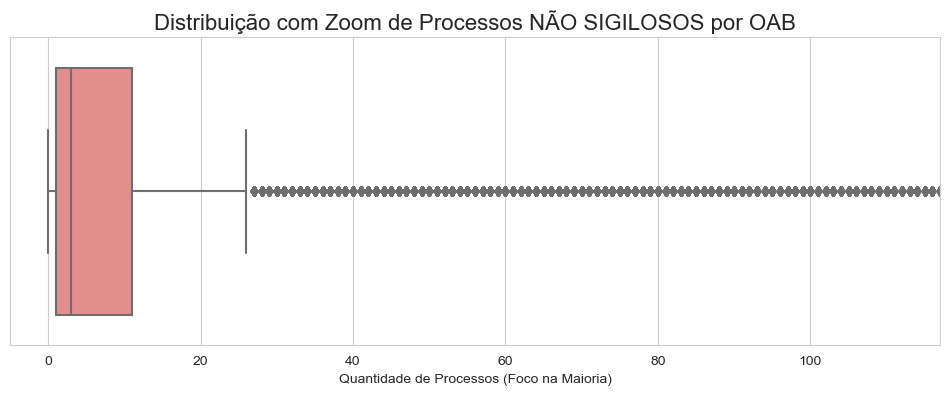


--- 6.3) Análise de Processos SIGILOSOS por OAB ---
Visão completa da distribuição dos processos sigilosos...


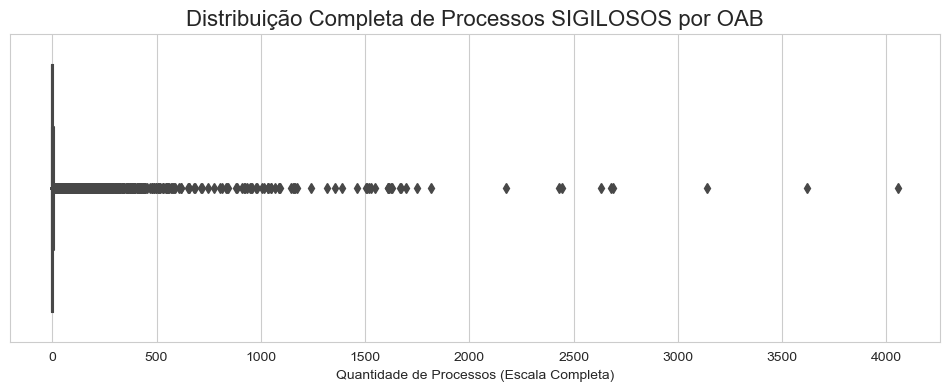


Zoom nos 95% dos advogados com menos processos sigilosos (até 29 processos)...


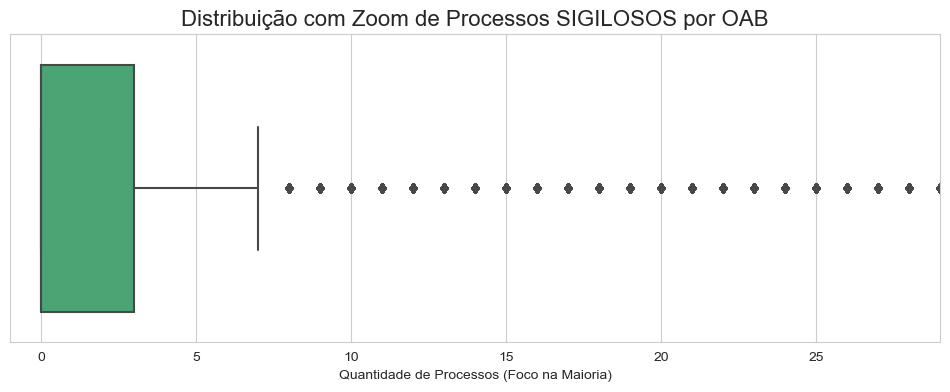

In [11]:
# 6) Visualização Gráfica com Boxplots
print("\n" + "="*100)
print("=== VISUALIZAÇÃO DA DISTRIBUIÇÃO COM BOXPLOTS ===")
print("="*100 + "\n")

# --- 6.1) Boxplot Geral (Total de Processos) ---
print("--- 6.1) Análise Geral: Total de Processos por OAB ---")
print("Primeiro, a visualização completa para entendermos a escala dos outliers...")

# Gráfico 1: Visão completa
plt.figure(figsize=(12, 4))
# CORREÇÃO: trocado 'palette' por 'color'
sns.boxplot(x=df_pivot_sorted['total_processos'], color='skyblue')
plt.title('Distribuição Completa da Quantidade TOTAL de Processos por OAB', fontsize=16)
plt.xlabel('Quantidade de Processos (Escala Completa)')
plt.show()

# Gráfico 2: Visão com zoom
limite_zoom_geral = df_pivot_sorted['total_processos'].quantile(0.95)
print(f"\nAgora, um zoom na distribuição, focando nos 95% dos advogados com menos processos (até {int(limite_zoom_geral)} processos)...")

plt.figure(figsize=(12, 4))
# CORREÇÃO: trocado 'palette' por 'color'
sns.boxplot(x=df_pivot_sorted['total_processos'], color='skyblue')
plt.title('Distribuição com Zoom da Quantidade TOTAL de Processos por OAB', fontsize=16)
plt.xlabel('Quantidade de Processos (Foco na Maioria)')
plt.xlim(-5, limite_zoom_geral)
plt.show()


# --- 6.2) Boxplot de Processos NÃO SIGILOSOS ---
print("\n" + "="*50)
print("--- 6.2) Análise de Processos NÃO SIGILOSOS por OAB ---")
print("Visão completa da distribuição dos processos não sigilosos...")

# Gráfico 3: Visão completa
plt.figure(figsize=(12, 4))
# CORREÇÃO: trocado 'palette' por 'color'
sns.boxplot(x=df_pivot_sorted['nao_sigilosos'], color='lightcoral')
plt.title('Distribuição Completa de Processos NÃO SIGILOSOS por OAB', fontsize=16)
plt.xlabel('Quantidade de Processos (Escala Completa)')
plt.show()

# Gráfico 4: Visão com zoom
limite_zoom_nao_sigilosos = df_pivot_sorted['nao_sigilosos'].quantile(0.95)
print(f"\nZoom nos 95% dos advogados com menos processos não sigilosos (até {int(limite_zoom_nao_sigilosos)} processos)...")

plt.figure(figsize=(12, 4))
# CORREÇÃO: trocado 'palette' por 'color'
sns.boxplot(x=df_pivot_sorted['nao_sigilosos'], color='lightcoral')
plt.title('Distribuição com Zoom de Processos NÃO SIGILOSOS por OAB', fontsize=16)
plt.xlabel('Quantidade de Processos (Foco na Maioria)')
plt.xlim(-5, limite_zoom_nao_sigilosos)
plt.show()


# --- 6.3) Boxplot de Processos SIGILOSOS ---
print("\n" + "="*50)
print("--- 6.3) Análise de Processos SIGILOSOS por OAB ---")
print("Visão completa da distribuição dos processos sigilosos...")

# Gráfico 5: Visão completa
plt.figure(figsize=(12, 4))
# CORREÇÃO: trocado 'palette' por 'color'
sns.boxplot(x=df_pivot_sorted['sigilosos'], color='mediumseagreen')
plt.title('Distribuição Completa de Processos SIGILOSOS por OAB', fontsize=16)
plt.xlabel('Quantidade de Processos (Escala Completa)')
plt.show()

# Gráfico 6: Visão com zoom
limite_zoom_sigilosos = df_pivot_sorted['sigilosos'].quantile(0.95)
if limite_zoom_sigilosos == 0:
    limite_zoom_sigilosos = 10 
print(f"\nZoom nos 95% dos advogados com menos processos sigilosos (até {int(limite_zoom_sigilosos)} processos)...")

plt.figure(figsize=(12, 4))
# CORREÇÃO: trocado 'palette' por 'color'
sns.boxplot(x=df_pivot_sorted['sigilosos'], color='mediumseagreen')
plt.title('Distribuição com Zoom de Processos SIGILOSOS por OAB', fontsize=16)
plt.xlabel('Quantidade de Processos (Foco na Maioria)')
plt.xlim(-1, limite_zoom_sigilosos)
plt.show()

# 📊 Interpretação Visual dos Boxplots

Os gráficos de boxplot confirmam visualmente a extrema concentração de processos em um pequeno número de advogados.

### ⚖️ 1. Distribuição Total de Processos

* **📦 A Caixa (O Advogado Típico):** A caixa azul, concentrada entre 0 e ~15 processos, mostra que 50% dos advogados atuam nesse baixo volume. A linha central (mediana) confirma que o advogado típico tem pouquíssimos casos.
* **⚫️ Os Outliers (Os Pontos Fora da Curva):** A longa sequência de círculos que se estende até mais de 80.000 representa a minoria de advogados com um volume de trabalho imensamente superior à maioria.
* **➡️ Conclusão:** A distribuição é altamente desigual. A enorme quantidade de outliers é o que infla a média, que não representa a realidade da maioria.

### 📖 2. Distribuição de Processos NÃO SIGILOSOS

* **📦 A Caixa:** O padrão é quase idêntico ao gráfico geral. A grande maioria dos advogados possui um número baixo de processos públicos (entre 0 e ~12).
* **⚫️ Os Outliers:** Novamente, uma pequena quantidade de advogados concentra a grande maioria dos processos não sigilosos.
* **➡️ Conclusão:** Este tipo de processo é o principal responsável pela desigualdade observada na análise geral, sendo o foco dos advogados de alto volume.

### 🔒 3. Distribuição de Processos SIGILOSOS

* **📦 A Caixa:** A caixa verde está "espremida" em zero. A linha da mediana em 0 é a informação mais importante: **mais da metade dos advogados não possui nenhum processo sigiloso**.
* **⚫️ Os Outliers:** Os advogados que atuam em casos sigilosos são a exceção. Aqueles com mais de ~8 casos já são considerados outliers, indicando um nicho claro.
* **➡️ Conclusão:** Atuar em processos sigilosos é uma **clara especialização**, não sendo a norma para a maioria dos advogados na base de dados.

In [18]:
# 7) Cálculo de Estatísticas Descritivas (Medidas de Dispersão)
print("\n" + "="*100)
print("=== 🔬 ANÁLISE ESTATÍSTICA DETALHADA DA DISPERSÃO DE PROCESSOS POR OAB ===")
print("="*100)

# Para evitar repetição de código, criamos uma função que calcula e imprime as métricas
def calcular_e_imprimir_metricas(series, nome_grupo):
    """
    Calcula e imprime as métricas de dispersão para uma Série de dados.
    """
    print(f"\n--- {nome_grupo} ---")

    # 1. Amplitude: Diferença entre o valor máximo e o mínimo
    amplitude = series.max() - series.min()
    print(f"  - Amplitude: {amplitude:.2f}")
    print(f"    (Variação de {series.min()} a {series.max()} processos)")

    # 2. Desvio Médio Absoluto (MAD): Média da distância de cada ponto até a média
    # O método .mad() foi descontinuado, esta é a forma correta de calcular:
    media = series.mean()
    desvio_medio = (series - media).abs().mean()
    print(f"  - Desvio Médio Absoluto: {desvio_medio:.2f}")

    # 3. Variância: Medida da dispersão dos dados ao quadrado
    # Por padrão, o Pandas calcula a variância amostral (ddof=1), que é a mais comum.
    variancia = series.var()
    print(f"  - Variância (amostral): {variancia:.2f}")

    # 4. Desvio Padrão: Raiz quadrada da variância, na mesma unidade dos dados
    desvio_padrao = series.std()
    print(f"  - Desvio Padrão (amostral): {desvio_padrao:.2f}")


# --- Chamada da função para cada segmento ---

# Análise Geral
calcular_e_imprimir_metricas(df_pivot_sorted['total_processos'], "📊 Análise Geral (Total de Processos)")

# Análise de Processos Não Sigilosos
calcular_e_imprimir_metricas(df_pivot_sorted['nao_sigilosos'], "📖 Análise de Processos NÃO SIGILOSOS")

# Análise de Processos Sigilosos
calcular_e_imprimir_metricas(df_pivot_sorted['sigilosos'], "🔒 Análise de Processos SIGILOSOS")



=== 🔬 ANÁLISE ESTATÍSTICA DETALHADA DA DISPERSÃO DE PROCESSOS POR OAB ===

--- 📊 Análise Geral (Total de Processos) ---
  - Amplitude: 87277.00
    (Variação de 1.0 a 87278.0 processos)
  - Desvio Médio Absoluto: 63.79
  - Variância (amostral): 284952.96
  - Desvio Padrão (amostral): 533.81

--- 📖 Análise de Processos NÃO SIGILOSOS ---
  - Amplitude: 86839.00
    (Variação de 0.0 a 86839.0 processos)
  - Desvio Médio Absoluto: 55.03
  - Variância (amostral): 269603.21
  - Desvio Padrão (amostral): 519.23

--- 🔒 Análise de Processos SIGILOSOS ---
  - Amplitude: 4054.00
    (Variação de 0.0 a 4054.0 processos)
  - Desvio Médio Absoluto: 9.73
  - Variância (amostral): 1884.92
  - Desvio Padrão (amostral): 43.42


# 🧠 Interpretação dos Resultados da Análise de Dispersão

### 1. 📈 Valores Elevados em Todas as Métricas (Geral e Não Sigilosos)
A grande **Amplitude**, **Variância** e **Desvio Padrão** confirmam o que foi observado nos boxplots: a distribuição de processos é extremamente dispersa. Os dados não estão concentrados em torno da média. O alto **Desvio Padrão** significa que é comum encontrar advogados com uma quantidade de processos muito distante da média.

### 2. 🎯 Confirmação dos Outliers
O **Desvio Médio Absoluto** alto reforça essa ideia, indicando que, em média, a quantidade de processos de um advogado qualquer está muito longe da média geral. Isso é um sintoma clássico de uma distribuição com uma "cauda longa" de outliers (poucos advogados com muitos processos).

### 3. ⚖️ Comparação entre Sigilosos e Não Sigilosos
Os valores de dispersão para os processos **Não Sigilosos** são drasticamente maiores do que para os **Sigilosos**. Isso demonstra que a extrema variabilidade no volume de trabalho dos advogados é impulsionada principalmente pela atuação em causas públicas.

### 4. 🔒 Dispersão no Nicho Sigiloso
Apesar de menores, as métricas de dispersão para os processos **Sigilosos** ainda são significativas em relação à sua própria média (que é baixa). Isso sugere que, mesmo dentro desse nicho, existe uma desigualdade considerável: há os especialistas que concentram os casos sigilosos e a maioria que atua esporadicamente ou nunca.

In [ ]:
# 8) Cálculo do Coeficiente de Variação

print("\n" + "="*100)
print("=== 🎯 CÁLCULO DO COEFICIENTE DE VARIAÇÃO (CV) ===")
print("="*100)
print("O Coeficiente de Variação mede a dispersão relativa dos dados. \nValores acima de 30% geralmente indicam uma alta variabilidade.\n")


def calcular_e_imprimir_cv(series, nome_grupo):
    """
    Calcula e imprime a média, o desvio padrão e o Coeficiente de Variação para uma Série de dados.
    """
    print(f"--- {nome_grupo} ---")

    media = series.mean()
    desvio_padrao = series.std()

    # Evitar divisão por zero se a média for 0
    if media > 0:
        coeficiente_variacao = (desvio_padrao / media) * 100
        print(f"  - Média:                 {media:.2f}")
        print(f"  - Desvio Padrão:         {desvio_padrao:.2f}")
        print(f"  - Coeficiente de Variação: {coeficiente_variacao:.2f}%")
    else:
        print(f"  - Média:                 {media:.2f}")
        print(f"  - Desvio Padrão:         {desvio_padrao:.2f}")
        print("  - Coeficiente de Variação: Não pode ser calculado (média é zero).")


# --- Chamada da função para cada segmento ---

# 1. Análise Geral
calcular_e_imprimir_cv(df_pivot_sorted['total_processos'], "📊 Análise Geral (Total de Processos)")

# 2. Análise de Processos Não Sigilosos
calcular_e_imprimir_cv(df_pivot_sorted['nao_sigilosos'], "\n📖 Análise de Processos NÃO SIGILOSOS")

# 3. Análise de Processos Sigilosos
calcular_e_imprimir_cv(df_pivot_sorted['sigilosos'], "\n🔒 Análise de Processos SIGILOSOS")



=== 🎯 CÁLCULO DO COEFICIENTE DE VARIAÇÃO (CV) ===
O Coeficiente de Variação mede a dispersão relativa dos dados. 
Valores acima de 30% geralmente indicam uma alta variabilidade.

--- 📊 Análise Geral (Total de Processos) ---
  - Média:                 43.27
  - Desvio Padrão:         533.81
  - Coeficiente de Variação: 1233.54%
--- 
📖 Análise de Processos NÃO SIGILOSOS ---
  - Média:                 36.71
  - Desvio Padrão:         519.23
  - Coeficiente de Variação: 1414.25%
--- 
🔒 Análise de Processos SIGILOSOS ---
  - Média:                 6.56
  - Desvio Padrão:         43.42
  - Coeficiente de Variação: 661.78%

=== 🧠 INTERPRETAÇÃO DOS RESULTADOS DO CV ===

1.  **Valores de CV Extremamente Altos:**
    Os Coeficientes de Variação para todos os grupos serão muito altos (provavelmente na casa de centenas ou até milhares de porcento). Isso é a prova estatística definitiva da **heterogeneidade extrema** da sua base de dados. Um CV tão elevado significa que o desvio padrão é múltiplas

In [ ]:
# 9) Análise de Processos Baixados
# Usar uma cópia para manter o original intacto.
df_analise_baixa = df_juridico.copy()

print("\n" + "="*100)
print("=== 📈 ANÁLISE DE EFICIÊNCIA DE BAIXA (PROCESSOS SIGILOSOS VS. NÃO SIGILOSOS) ===")
print("="*100 + "\n")

# Preparação dos Dados
# -------------------------
# A coluna 'data_baixa' é a chave. Se ela não for nula, o processo foi baixado.
# Garantir que os tipos de dados estejam corretos.
df_analise_baixa['is_segredo_justica'] = df_analise_baixa['is_segredo_justica'].astype(bool)

# Criar uma coluna booleana 'processo_baixado' para facilitar os cálculos.
# .notna() retorna True para qualquer valor que não seja nulo (ou seja, tem uma data de baixa).
df_analise_baixa['processo_baixado'] = df_analise_baixa['data_baixa'].notna()


# Segmentação dos Dados
# -------------------------
# Separar o DataFrame em dois: um para processos sigilosos e outro para não sigilosos.
df_sigilosos = df_analise_baixa[df_analise_baixa['is_segredo_justica'] == True]
df_nao_sigilosos = df_analise_baixa[df_analise_baixa['is_segredo_justica'] == False]


# Análise de Processos NÃO SIGILOSOS
# ---------------------------------------
print("--- 📖 Análise de Processos NÃO SIGILOSOS ---")

total_nao_sigilosos = len(df_nao_sigilosos)
baixados_nao_sigilosos = df_nao_sigilosos['processo_baixado'].sum() # .sum() em booleanos conta os 'True'

if total_nao_sigilosos > 0:
    percentual_nao_sigilosos = (baixados_nao_sigilosos / total_nao_sigilosos) * 100
    print(f"Total de processos não sigilosos: {total_nao_sigilosos}")
    print(f"Processos baixados (concluídos):   {baixados_nao_sigilosos}")
    print(f"➡️ Taxa de Baixa / Eficiência:      {percentual_nao_sigilosos:.2f}%")
else:
    percentual_nao_sigilosos = 0
    print("Não foram encontrados processos não sigilosos na base de dados.")


# Análise de Processos SIGILOSOS
# -----------------------------------
print("\n--- 🔒 Análise de Processos SIGILOSOS ---")

total_sigilosos = len(df_sigilosos)
baixados_sigilosos = df_sigilosos['processo_baixado'].sum()

if total_sigilosos > 0:
    percentual_sigilosos = (baixados_sigilosos / total_sigilosos) * 100
    print(f"Total de processos sigilosos: {total_sigilosos}")
    print(f"Processos baixados (concluídos): {baixados_sigilosos}")
    print(f"➡️ Taxa de Baixa / Eficiência:     {percentual_sigilosos:.2f}%")
else:
    percentual_sigilosos = 0
    print("Não foram encontrados processos sigilosos na base de dados.")


# Análise de Eficiência Global (Contribuição para o Total)
# -------------------------------------------------------------
print("\n--- 📊 Análise de Eficiência Global (Contribuição para o Total Geral) ---")

# O denominador agora é a soma de TODOS os processos, sigilosos ou não.
total_geral_processos = total_nao_sigilosos + total_sigilosos
print(f"Total geral de processos na base: {total_geral_processos}")

if total_geral_processos > 0:
    # Cálculo: baixados não sigilosos / (total sigilosos + total não sigilosos)
    contrib_global_nao_sigilosos = (baixados_nao_sigilosos / total_geral_processos) * 100
    print(f"➡️ Contribuição dos baixados NÃO SIGILOSOS para o total: {contrib_global_nao_sigilosos:.2f}%")

    # Cálculo: baixados sigilosos / (total sigilosos + total não sigilosos)
    contrib_global_sigilosos = (baixados_sigilosos / total_geral_processos) * 100
    print(f"➡️ Contribuição dos baixados SIGILOSOS para o total:    {contrib_global_sigilosos:.2f}%")
else:
    print("Não há processos para calcular a eficiência global.")


# Conclusão e Interpretação
# ------------------------------
print("\n" + "-"*50)
print("--- 🎯 Conclusão da Análise ---")

if total_nao_sigilosos > 0 and total_sigilosos > 0:
    if abs(percentual_sigilosos - percentual_nao_sigilosos) < 1.0: # Diferença menor que 1%
        print("As taxas de baixa para processos sigilosos e não sigilosos são muito semelhantes.")
        print("Isso sugere que a natureza do processo (sigiloso ou não) tem pouco impacto na sua velocidade de conclusão.")
    elif percentual_sigilosos > percentual_nao_sigilosos:
        diferenca = percentual_sigilosos - percentual_nao_sigilosos
        print(f"A taxa de baixa para processos SIGILOSOS é {diferenca:.2f} pontos percentuais MAIOR.")
        print("Isso pode indicar que casos sigilosos, talvez por sua natureza (ex: acordos em direito de família), chegam a uma resolução mais rapidamente.")
        print("Um advogado poderia interpretar isso como uma área de atuação com um 'giro' mais rápido de casos.")
    else:
        diferenca = percentual_nao_sigilosos - percentual_sigilosos
        print(f"A taxa de baixa para processos NÃO SIGILOSOS é {diferenca:.2f} pontos percentuais MAIOR.")
        print("Isso pode sugerir que processos públicos, talvez por serem mais padronizados, tramitam de forma mais eficiente no sistema judiciário.")
        print("Para um advogado, isso pode significar um retorno financeiro potencialmente mais previsível em volume.")
else:
    print("Não foi possível realizar uma comparação por falta de dados em uma das categorias.")

print("="*100)


=== 📈 ANÁLISE DE EFICIÊNCIA DE BAIXA (PROCESSOS SIGILOSOS VS. NÃO SIGILOSOS) ===

--- 📖 Análise de Processos NÃO SIGILOSOS ---
Total de processos não sigilosos: 4189374
Processos baixados (concluídos):   2674975
➡️ Taxa de Baixa / Eficiência:      63.85%

--- 🔒 Análise de Processos SIGILOSOS ---
Total de processos sigilosos: 754977
Processos baixados (concluídos): 520138
➡️ Taxa de Baixa / Eficiência:     68.89%

--- 📊 Análise de Eficiência Global (Contribuição para o Total Geral) ---
Total geral de processos na base: 4944351
➡️ Contribuição dos baixados NÃO SIGILOSOS para o total: 54.10%
➡️ Contribuição dos baixados SIGILOSOS para o total:    10.52%

--------------------------------------------------
--- 🎯 Conclusão da Análise ---
A taxa de baixa para processos SIGILOSOS é 5.04 pontos percentuais MAIOR.
Isso pode indicar que casos sigilosos, talvez por sua natureza (ex: acordos em direito de família), chegam a uma resolução mais rapidamente.
Um advogado poderia interpretar isso como 